In [5]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

In [6]:
# Example usage
mechanism = 'Burke2012_s9r23.yaml'  # Example mechanism
gas_state = {
    'initial_temperature':  300,    # K
    'initial_pressure':     101325, # Pa
    'fuel_composition':     'H2:1',
    'oxidizer_composition': 'O2:0.21,N2:0.79',
    'equivalence_ratio':    1.0
}

import deepflame_node.one_d_flame_setup as odf

flame_speed, flame_thickness, final_flame = odf.calculate_laminar_flame_properties(mechanism, gas_state)
case_params = odf.update_case_parameters(mechanism, gas_state, flame_speed, flame_thickness)

odf.update_one_d_sample_config(case_params, gas_state)
odf.create_0_species_files(case_params)
odf.update_set_fields_dict(case_params)

Solving premixed flame...
Laminar Flame Speed      :   2.3489328863 m/s
Laminar Flame Thickness  :   0.0003694362 m
Flame Thickness: 3.69e-04
Flame Speed: 2.35e+00
Domain Width: 1.85e-03
Domain Length: 1.85e-02
Target Time Step: 1.00e-06
Chemical Time Scale: 1.57e-04
Sample Time Steps: 1.00e+02
Estimated Time Step: 1.57e-05
Estimated Sim Time: 1.59e-03
Estimated Write Time Step: 1.57e-05


In [7]:
# Run the Allrun script to simulate the flame

In [8]:
import subprocess

fields_str = f"T p {' '.join(case_params['unburnt_gas'].species_names)}"
command = f"reconstructPar -fields '({fields_str})'"
print(command)

# Execute the command after the simulation finished

reconstructPar -fields '(T p H H2 O OH H2O O2 HO2 H2O2 N2)'


In [10]:
from deepflame_node.utils import is_numeric_string, load_openfoam_scalar_from_file

temp_gas = ct.Solution(mechanism)
sample_dims_list = ['T', 'p'] + temp_gas.species_names
print(sample_dims_list)

main_dir = Path('.')
time_dirs = [dir for dir in main_dir.iterdir() if dir.is_dir() and is_numeric_string(dir.name)]
sorted_time_dirs = sorted(time_dirs, key=lambda x: float(x.name))[1:]
print(len(sorted_time_dirs))

data_collector = []

for time_dir in sorted_time_dirs:
    time_dim_arrays = []
    
    for filename in sample_dims_list:
        file_path = time_dir / filename
        dim_array = load_openfoam_scalar_from_file(file_path)
        time_dim_arrays.append(dim_array)
    
    time_array = np.concatenate(time_dim_arrays, axis=1)
    data_collector.append(time_array)

data_array = np.concatenate(data_collector, axis=0)
print(data_array.shape)
print(data_array[0])

np.save('data_array.npy', data_array)

['T', 'p', 'H', 'H2', 'O', 'OH', 'H2O', 'O2', 'HO2', 'H2O2', 'N2']
101
(50500, 11)
[3.00026e+02 1.01411e+05 1.39350e-41 2.85116e-02 1.01528e-47 7.71063e-48
 3.51508e-48 2.26269e-01 3.64033e-38 6.17530e-53 7.45219e-01]


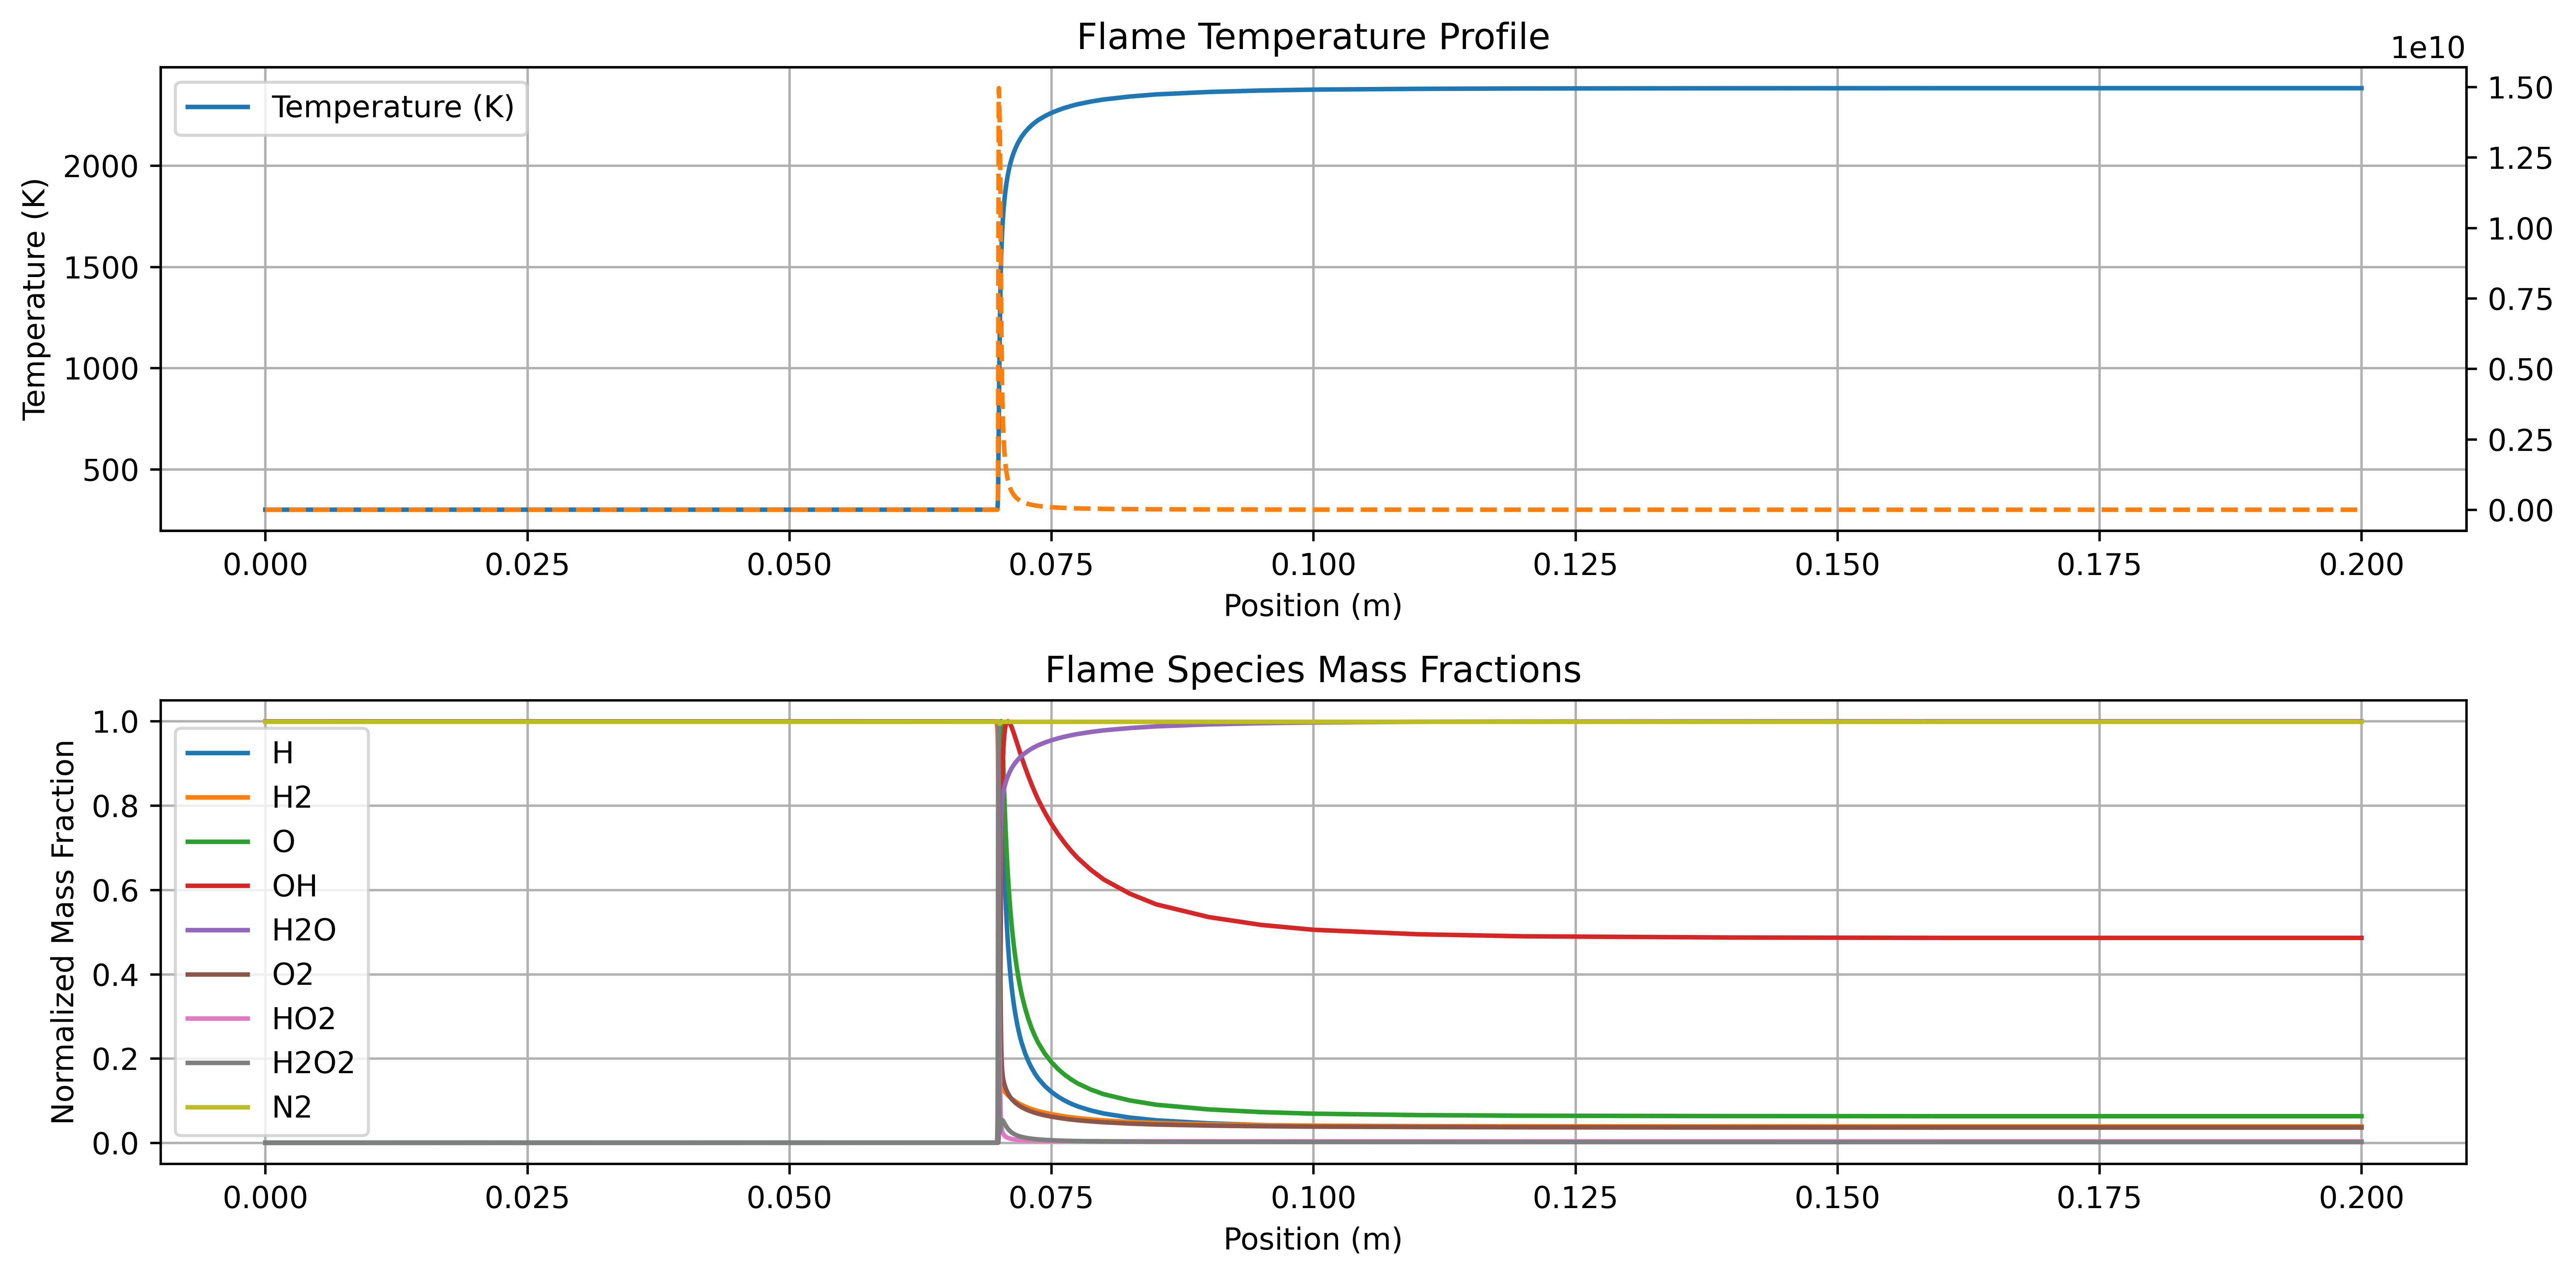

In [11]:
collected_data = final_flame.collect_data(cols=['grid', 'T', 'Y', 'heat_release_rate'])
z = collected_data['grid']
T = collected_data['T']
Y = collected_data['Y']
heat_release_rate = collected_data['heat_release_rate']


fig, ax = plt.subplots(2, 1, figsize=(12, 6), dpi=600)

# Plot temperature profile
ax[0].plot(z, T, label='Temperature (K)')
ax1 = ax[0].twinx()
ax1.plot(z, heat_release_rate, label='Heat Release Rate [W/m³]', color='C1', linestyle='--')
ax[0].set_xlabel('Position (m)')
ax[0].set_ylabel('Temperature (K)')
ax[0].set_title('Flame Temperature Profile')
ax[0].grid()
ax[0].legend()

# Plot species mass fractions
for i, species in enumerate(final_flame.species_names):
    ax[1].plot(z, Y[:, i] / np.max(Y[:, i]), label=species)
ax[1].set_xlabel('Position (m)')
ax[1].set_ylabel('Normalized Mass Fraction')
ax[1].set_title('Flame Species Mass Fractions')
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.show()

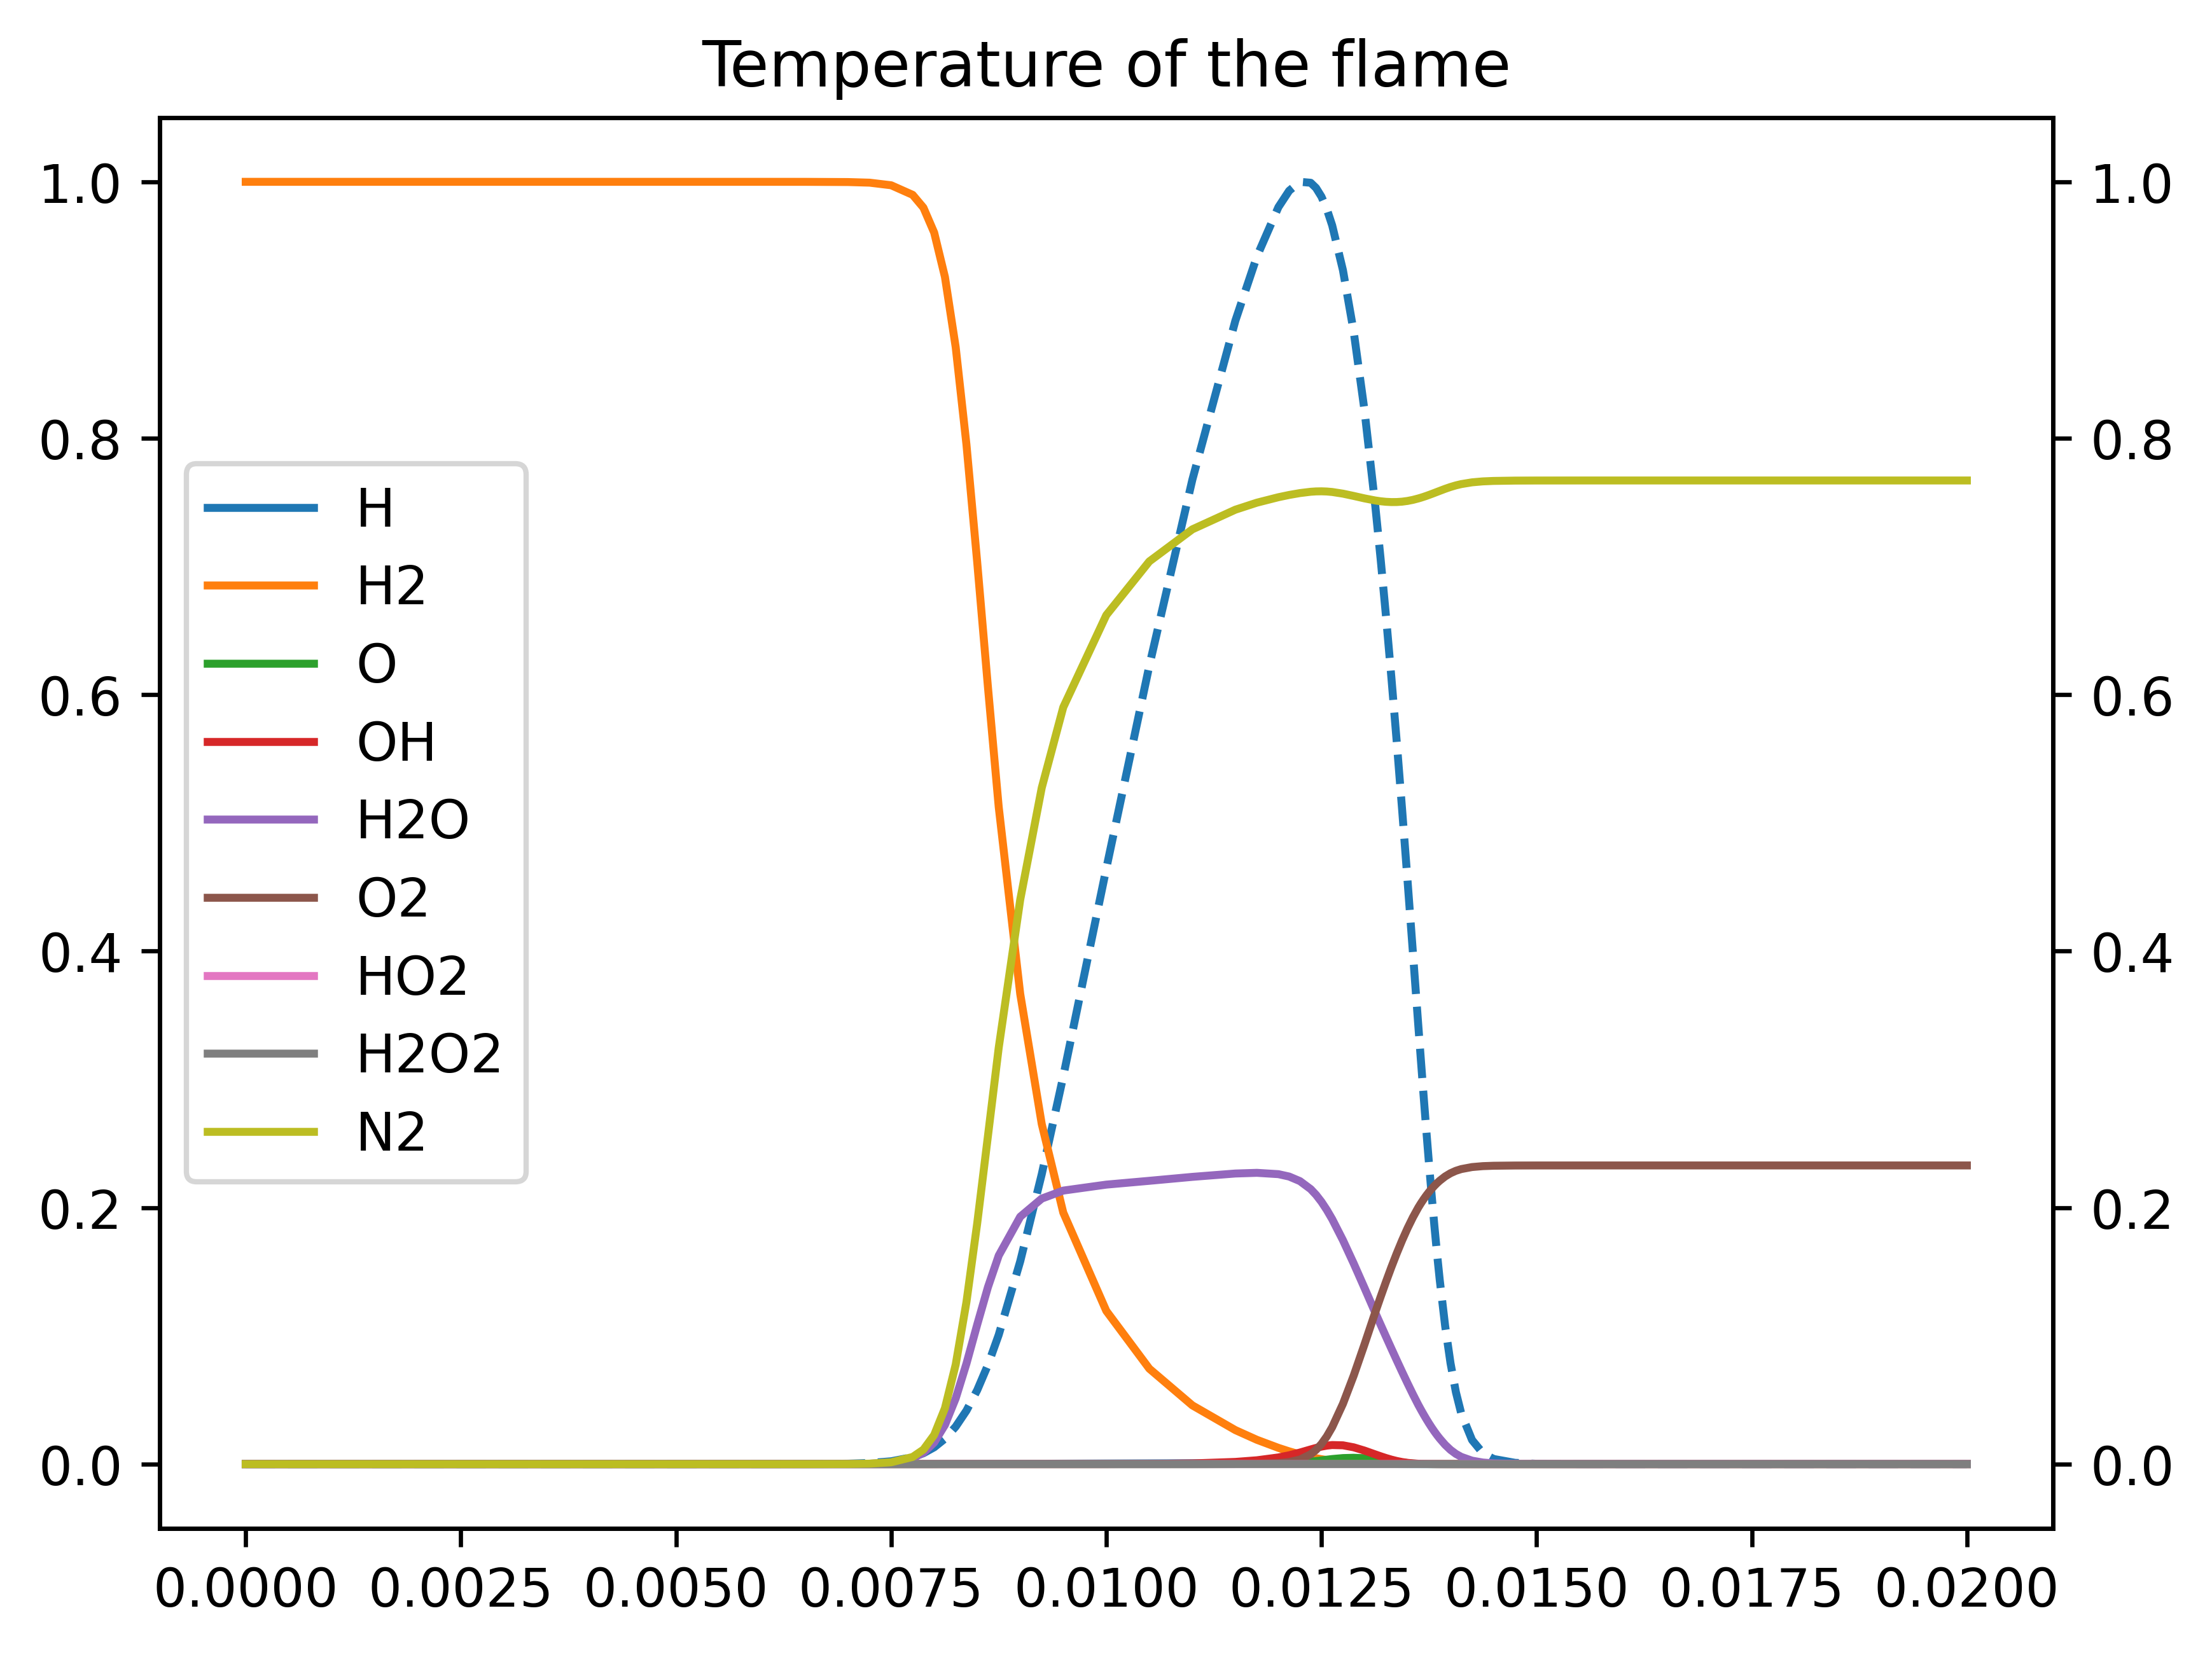

In [12]:
p = ct.one_atm  # pressure
tin_f = 300.0  # fuel inlet temperature
tin_o = 300.0  # oxidizer inlet temperature
mdot_o = 0.72  # kg/m^2/s
mdot_f = 0.24  # kg/m^2/s

comp_o = 'O2:0.21,N2:0.79'  # air composition
comp_f = 'H2:1'  # fuel composition

width = 0.02  # Distance between inlets is 2 cm

loglevel = 0  # amount of diagnostic output (0 to 5)

# Create the gas object used to evaluate all thermodynamic, kinetic, and
# transport properties.
gas = ct.Solution('Burke2012_s9r23.yaml')
gas.TP = gas.T, p

# Create an object representing the counterflow flame configuration,
# which consists of a fuel inlet on the left, the flow in the middle,
# and the oxidizer inlet on the right.
f = ct.CounterflowDiffusionFlame(gas, width=width)

# Set the state of the two inlets
f.fuel_inlet.mdot = mdot_f
f.fuel_inlet.X = comp_f
f.fuel_inlet.T = tin_f

f.oxidizer_inlet.mdot = mdot_o
f.oxidizer_inlet.X = comp_o
f.oxidizer_inlet.T = tin_o

# Set the boundary emissivities
f.boundary_emissivities = 0.0, 0.0
# Turn radiation off
f.radiation_enabled = False

f.set_refine_criteria(ratio=4, slope=0.2, curve=0.3, prune=0.04)

f.solve(loglevel, auto=True)



flame_result = f.to_solution_array()
collected_data = flame_result.collect_data(cols=['grid', 'T', 'Y', 'heat_release_rate'])

fig, ax = plt.subplots(dpi=600)
ax1 = ax.twinx()
ax.plot(
    collected_data['grid'], 
    (collected_data['T'] - min(collected_data['T'])) / (max(collected_data['T']) - min(collected_data['T'])), 
    linestyle='--'
)

for i, species in enumerate(gas.species_names):
    ax1.plot(
        collected_data['grid'], 
        collected_data['Y'][:, i],
        label=species,
    )
ax.set_title('Temperature of the flame')
# ax.set(ylim=(0,2500), xlim=(0.000, 0.020))
ax1.legend()

plt.show()
plt.close()